In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)


In [7]:
#reflect the tables
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

- Design a query to retrieve the last 12 months of precipitation data and plot the results
- Calculate the date 1 year ago from the last data point in the database
- Perform a query to retrieve the data and precipitation scores
- Save the query results as a Pandas DataFrame and set the index to the date column
- Sort the dataframe by date
- Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [12]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > '2016-08-23').all()


# Load the results into a pandas dataframe. Set the index to the date column
prcp_df = pd.DataFrame(results).set_index('date')
prcp_df = prcp_df.sort_values(by = 'date').dropna()
prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


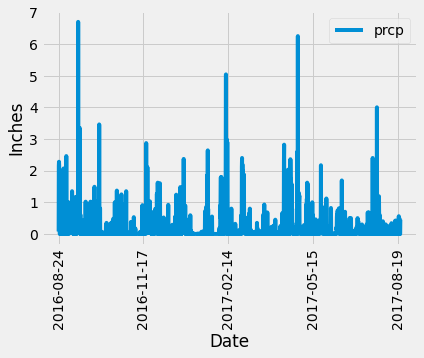

In [13]:
#Plot the data using Pandas Matplotlib
prcp_df.plot(rot = 90)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.savefig("12 mnth prcp.png")

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count() 


9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.date)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').\
    group_by(measurement.station).all()
    

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

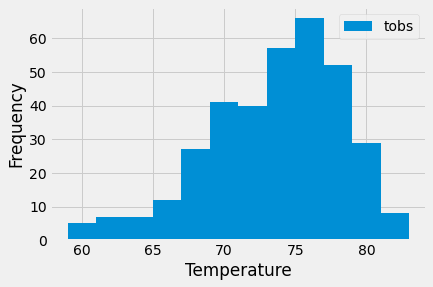

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date > '2016-08-23').\
    filter(measurement.station == 'USC00519281').all()

#convert to dataframe
temp_results_df = pd.DataFrame(temp_results)

#create histogram
temp_results_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()



## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """    

    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-15', '2017-06-20'))

[(72.0, 76.74358974358974, 80.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
t_result = calc_temps('2016-06-15','2016-06-20')[0]

t_result

(69.0, 75.51282051282051, 80.0)

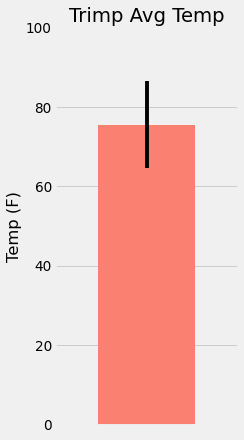

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [t_result[1]]
yerr = [(t_result[2] - t_result[0])]

plt.figure(figsize=(3, 7), dpi=70)
plt.bar(x_pos,y_pos,color='salmon',yerr=yerr)
plt.xlim(-0.75,0.75)
plt.ylabel("Temp (F)")
plt.title("Trimp Avg Temp")
plt.ylim(0, 100)
plt.tick_params(axis='x', which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')

plt.show()

In [54]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
st_results = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation, measurement.prcp).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= '2016-06-15').\
    filter(measurement.date <= '2016-06-20').\
    group_by(station.station).\
    order_by(measurement.prcp.desc()).all()

#create padas DF
bonus_df = pd.DataFrame(st_results, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'PrcpTotal'])

bonus_df

,Station,Name,Latitude,Longitude,Elevation,PrcpTotal
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.38
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.68
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.25
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.18
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.18
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.02
6,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.01


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("05-30")

[(69.0, 74.33333333333333, 81.0)]

In [49]:
# calculate the daily normals for your trip
day_one = daily_normals("06-15")
day_two = daily_normals("06-16")
day_three = daily_normals("06-17")
day_four = daily_normals("06-18")
day_five = daily_normals("06-19")
day_six = daily_normals("06-20")

# push each tuple of calculations into a list called `normals`
temp_tuple = ((day_one),(day_two),(day_three), (day_four), (day_five), day_six)

temp_list = [x for x, in temp_tuple]

temp_list

[(67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0)]

In [57]:
# Set the start and end date of the trip
start = '2016-06-15'
end = '2016-06-20'

# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(start, '%Y-%m-%d')
end_date = dt.datetime.strptime(end, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings


# Loop through the list of %m-%d strings and calculate the normals for each date
vacdates = []
normals = []
while (start_date <= end_date):
    vacdates.append(dt.datetime.strftime(start_date, '%Y-%m-%d'))
    datesformat = dt.datetime.strftime(start_date, '%m-%d')
    normals.append(list(np.ravel(daily_normals(datesformat))))
    start_date = start_date + dt.timedelta(days = 1)
    
normals   

[[67.0, 75.40350877192982, 81.0],
 [69.0, 75.41379310344827, 81.0],
 [68.0, 74.59322033898304, 81.0],
 [69.0, 74.60344827586206, 80.0],
 [70.0, 75.44067796610169, 82.0],
 [68.0, 73.96491228070175, 85.0]]

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
bonus2_df = pd.DataFrame(normals, columns=['Min Temp', 'Max Temp', 'Max Temp'])
bonus2_df['Date'] = vacdates
bonus2_df = bonus2_df.set_index('Date')

bonus2_df

,Min Temp,Max Temp,Max Temp
Date,,,
2016-06-15,67.0,75.403509,81.0
2016-06-16,69.0,75.413793,81.0
2016-06-17,68.0,74.593220,81.0
2016-06-18,69.0,74.603448,80.0
2016-06-19,70.0,75.440678,82.0
2016-06-20,68.0,73.964912,85.0


<module 'matplotlib.pyplot' from 'C:\\Users\\mv021\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

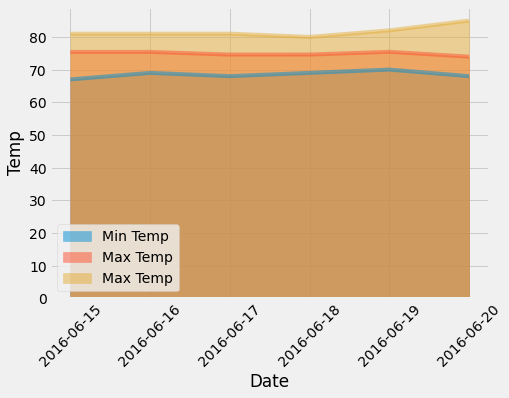

In [73]:
# Plot the daily normals as an area plot with `stacked=False`
bonus2_df.plot.area(figsize = (7,5), rot = 45, stacked=False)
plt.ylabel("Temp")
plt